In [1]:
%matplotlib inline
import requests
import json
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import credentials

Note on start and end date: This code is meant for beginning to end of a month. It should work for arbitrary periods, but if the end of February is enclosed in your interval, leap year offsets may have to be handled by the user and leap year related bugs fixed. 

In [2]:
baseurl = "https://www.ncdc.noaa.gov/cdo-web/api/v2/"
endpoint = "data"
custom_headers = {
    "token": credentials.token
}
datatypes = ["TAVG", "TMIN", "TMAX", "MDTX", 'MDTN', "PRCP", "SNOW"]
startdate = "2017-07-01"
enddate = "2017-07-31"
params = {
    "datatypeid": datatypes,
    "startdate": startdate,
    "enddate": enddate,
    "limit": 1000,
    "units": "standard",
}

In [3]:
STATIONFN = "AK_NCDC_FirstOrderStations.json"
with open(STATIONFN, "r") as source:
    stationdata = json.load(source)

## Request 1: Monthly summary

We start out querying the Global Summary of the Month dataset.

In [4]:
dataset = "GSOM"

In [5]:
fullbase = requests.compat.urljoin(baseurl, endpoint)

In [6]:
monthlysummary = {}
for station in stationdata:
    print(station['shortname'])
    params["stationid"] = station["id"]
    params["datasetid"] = dataset
    r = requests.get(
        fullbase, 
        headers=custom_headers,
        params=params,
    )
    results = json.loads(r.text)
    newdic = {}
    for result in results['results']:
        try:
            newdic[result["date"][:10]][result["datatype"]] = result["value"]
        except KeyError:
            newdic[result["date"][:10]] = {}
            newdic[result["date"][:10]][result["datatype"]] = result["value"]
    dataforstation = pd.DataFrame.from_dict(newdic, orient="index")
    normalsforstation = pd.DataFrame.from_csv("monthlynormals_{}.dat".format(station["shortname"]), sep='\t')
    normalsforstation.index = normalsforstation.index.month
    dataforstation.index = pd.to_datetime(dataforstation.index).month
    monthnum = dataforstation.index[0]
    stationmonthly = {}
    stationmonthly["T_avg_F"] = dataforstation["TAVG"][monthnum]
    stationmonthly["T_normal_F"] = normalsforstation["MLY-TAVG-NORMAL"][monthnum]
    stationmonthly["Precip_in"] = dataforstation["PRCP"][monthnum]
    stationmonthly["Precip_normal_in"] = normalsforstation["MLY-PRCP-NORMAL"][monthnum]
    try:
        stationmonthly["Snow"] = dataforstation["SNOW"][monthnum]
        stationmonthly["Snow_normal"] = normalsforstation["MLY-SNOW-NORMAL"][monthnum]
    except KeyError:
        pass
    monthlysummary[station["shortname"]] = stationmonthly


Fairbanks
Annette
Juneau
Yakutat
Kodiak
King Salmon
Homer
Cold Bay
Anchorage
St. Paul
Big Delta
Gulkana
McGrath
Talkeetna
Bettles
Bethel
Kotzebue
Nome
Barrow


In [19]:
r.request.url

'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?stationid=GHCND%3AUSW00027502&datasetid=GHCND&units=standard&limit=1000&startdate=2017-07-01&datatypeid=TAVG&datatypeid=TMIN&datatypeid=TMAX&datatypeid=MDTX&datatypeid=MDTN&datatypeid=PRCP&datatypeid=SNOW&enddate=2017-07-31'

In [9]:
summary = pd.DataFrame.from_dict(
    monthlysummary, 
    orient="index")
summary['Delta_precip'] = summary['Precip_in'] - summary['Precip_normal_in']
summary['Delta_precip_perc'] = summary['Delta_precip']/summary['Precip_normal_in'] * 100
summary['Precip_perc'] = summary['Delta_precip_perc'] + 100
summary['Delta_T'] = summary['T_avg_F'] - summary['T_normal_F']
summary['Delta_Snow'] = summary['Snow'] - summary['Snow_normal']

In [10]:
colorder = [
    "T_avg_F", "T_normal_F", 'Delta_T', 
    "Precip_in", 'Precip_normal_in', 'Delta_precip', 'Delta_precip_perc', 'Precip_perc',
    'Snow', 'Snow_normal', 'Delta_Snow'
]
summary[colorder]

,T_avg_F,T_normal_F,Delta_T,Precip_in,Precip_normal_in,Delta_precip,Delta_precip_perc,Precip_perc,Snow,Snow_normal,Delta_Snow
Anchorage,60.2,58.8,1.4,2.13,1.83,0.30,16.393443,116.393443,0.0,0.0,0.0
Annette,58.5,58.6,-0.1,2.71,4.65,-1.94,-41.720430,58.279570,0.0,0.0,0.0
Barrow,46.0,40.9,5.1,1.61,0.98,0.63,64.285714,164.285714,0.0,0.2,-0.2
Bethel,57.9,56.1,1.8,3.61,2.36,1.25,52.966102,152.966102,NaN,NaN,NaN
Bettles,64.4,59.7,4.7,1.82,2.36,-0.54,-22.881356,77.118644,0.0,0.0,0.0
Big Delta,63.2,60.2,3.0,3.39,2.68,0.71,26.492537,126.492537,NaN,NaN,NaN
Cold Bay,52.1,50.9,1.2,1.76,2.48,-0.72,-29.032258,70.967742,NaN,NaN,NaN
Fairbanks,65.7,62.5,3.2,1.94,2.16,-0.22,-10.185185,89.814815,0.0,0.0,0.0
Gulkana,59.4,57.6,1.8,1.84,1.81,0.03,1.657459,101.657459,NaN,NaN,NaN
Homer,57.0,54.6,2.4,1.15,1.55,-0.40,-25.806452,74.193548,NaN,NaN,NaN


**DO not run the next cell if you don't want to overwrite the output file** 

In [157]:
summary[colorder].to_csv("201707_Statewide_monthly.csv", float_format='%.2f')

## Request 2: Daily data 

Second, daily summaries.

In [11]:
dataset = "GHCND"
fullbase = requests.compat.urljoin(baseurl, endpoint)

Let's manipulate start and end data a little so that we're able to pick out the normals corresponding to daily observations. Normals are formally provided with the year set to 2010.

In [13]:
st = dt.datetime.strptime(startdate, "%Y-%m-%d") 
ed = dt.datetime.strptime(enddate, "%Y-%m-%d") 
normalsst = dt.datetime.strftime(dt.datetime(2010, st.month, st.day), "%Y-%m-%d")
normalsed = dt.datetime.strftime(dt.datetime(2010, ed.month, ed.day), "%Y-%m-%d")

The data plotted in the Statewide Summaries are mean daily precipitation and temperature, averaged over the available stations. For per-station, per-day plotting, the max and min daily temperature are of interest as well.

In [28]:
precip_daily_mean_perc_dep = {}
temp_daily_mean_dep = {}
temp_daily_max_dep = {}
temp_daily_min_dep = {}
for station in stationdata:
    print(station['shortname'])
    params["stationid"] = station["id"]
    params["datasetid"] = dataset
    r = requests.get(
        fullbase, 
        headers=custom_headers,
        params=params,
    )
    results = json.loads(r.text)
    newdic = {}
    for result in results['results']:
        try:
            newdic[result["date"][:10]][result["datatype"]] = result["value"]
        except KeyError:
            newdic[result["date"][:10]] = {}
            newdic[result["date"][:10]][result["datatype"]] = result["value"]
    dataforstation = pd.DataFrame.from_dict(newdic, orient="index")
    normalsforstation = pd.DataFrame.from_csv("dailynormals_{}.dat".format(station["shortname"]), sep='\t')
    normalsforstation.loc[normalsforstation.index.month == 7] 
    normalsforstation = normalsforstation.loc[normalsst:normalsed]
    normalsforstation.index = dataforstation.index
    dataforstation['TAVG_dep'] = dataforstation['TAVG'] - normalsforstation['DLY-TAVG-NORMAL']
    dataforstation['TMIN_dep'] = dataforstation['TMIN'] - normalsforstation['DLY-TMIN-NORMAL']
    dataforstation['TMAX_dep'] = dataforstation['TMAX'] - normalsforstation['DLY-TMAX-NORMAL']
    dataforstation['PRCP_dep'] = (dataforstation['PRCP'] - normalsforstation['DLY-PRCP-50PCTL'])/ normalsforstation['DLY-PRCP-50PCTL'] * 100
    temp_daily_mean_dep[station['shortname']] = dataforstation['TAVG_dep'].to_dict()
    precip_daily_mean_perc_dep[station['shortname']] = dataforstation['PRCP_dep'].to_dict()

Fairbanks
Annette
Juneau
Yakutat
Kodiak
King Salmon
Homer
Cold Bay
Anchorage
St. Paul
Big Delta
Gulkana
McGrath
Talkeetna
Bettles
Bethel
Kotzebue
Nome
Barrow


In [30]:
dataforstation

,SNOW,TAVG,TMAX,PRCP,TMIN,TAVG_dep,TMIN_dep,TMAX_dep,PRCP_dep
2017-07-01,0.0,36.0,40.0,0.00,31.0,-4.1,-3.2,-6.1,-100.0
2017-07-02,NaN,35.0,38.0,0.00,33.0,-5.3,-1.3,-8.3,-100.0
2017-07-03,0.0,38.0,47.0,0.00,35.0,-2.4,0.6,0.6,-100.0
2017-07-04,0.0,47.0,55.0,0.09,41.0,6.5,6.5,8.4,125.0
2017-07-05,0.0,47.0,57.0,0.20,45.0,6.4,10.4,10.3,400.0
2017-07-06,0.0,55.0,62.0,0.07,46.0,14.3,11.4,15.1,75.0
2017-07-07,0.0,48.0,53.0,0.07,44.0,7.2,9.3,6.0,40.0
2017-07-08,0.0,47.0,51.0,0.00,41.0,6.1,6.3,3.9,-100.0
2017-07-09,0.0,50.0,59.0,0.00,37.0,9.0,2.2,11.9,-100.0
2017-07-10,0.0,42.0,43.0,0.02,37.0,1.0,2.2,-4.2,-60.0


In [82]:
sns.set_style("white"
             )
sns.set_context("poster")

In [98]:
avg_temp_dep = pd.DataFrame.from_dict(
    temp_daily_mean_dep).mean(axis=1)
xlabels = pd.Series(list(range(1, len(avg_temp_dep)+1)), index=avg_temp_dep.index)
avg_temp_dep = pd.concat([avg_temp_dep, xlabels], axis=1 )
avg_temp_dep.columns = ['temp_dep', 'xlabel']
avg_temp_dep['positive'] = avg_temp_dep['temp_dep'] > 0

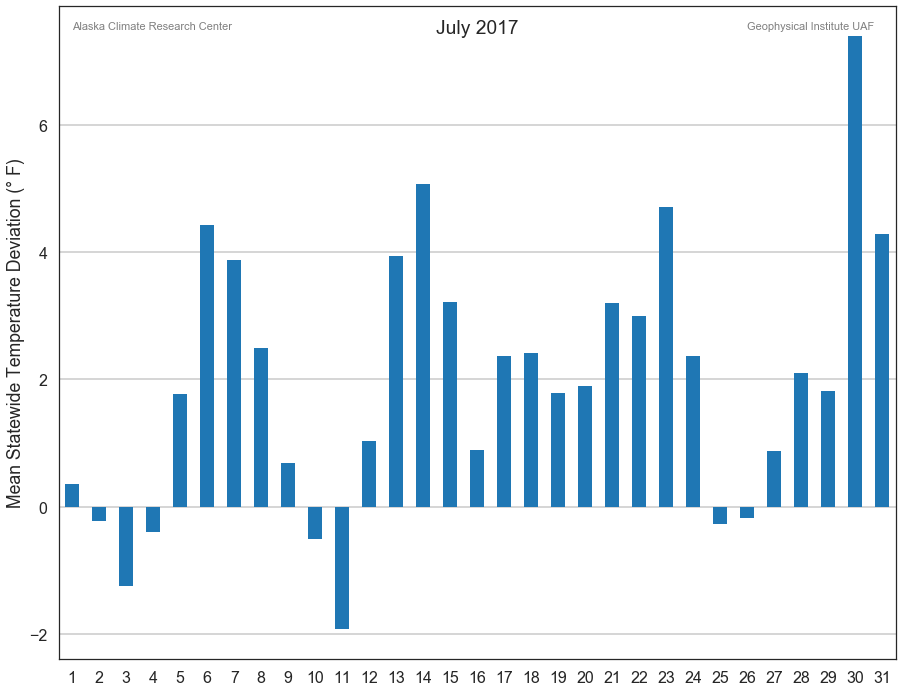

In [101]:
fig, ax1 = plt.subplots(figsize=(15, 12))
avg_temp_dep.plot(
    x='xlabel',
    y='temp_dep',
    kind='bar', 
    ax=ax1,
    legend=False,
)
ticklabels = ax1.set_xticklabels(avg_temp_dep['xlabel'], rotation=0)
ax1.text(0, 7.5, "Alaska Climate Research Center", fontsize=11, color="grey")
ax1.text(25, 7.5, "Geophysical Institute UAF", fontsize=11, color="grey")
ax1.set_ylabel("Mean Statewide Temperature Deviation (° F)")
ax1.set_xlabel("")
ax1.set_title("July 2017", y=0.95)
ax1.grid(True, axis='y')

In [78]:
avg_precip_dep = pd.DataFrame.from_dict(
    precip_daily_mean_perc_dep).mean(axis=1)
xlabels = pd.Series(list(range(1, len(avg_precip_dep)+1)), index=avg_precip_dep.index)
avg_precip_dep = pd.concat([avg_precip_dep, xlabels], axis=1 )
avg_precip_dep.columns = ['precip_dep', 'xlabel']
avg_precip_dep['positive'] = avg_precip_dep['precip_dep'] > 0

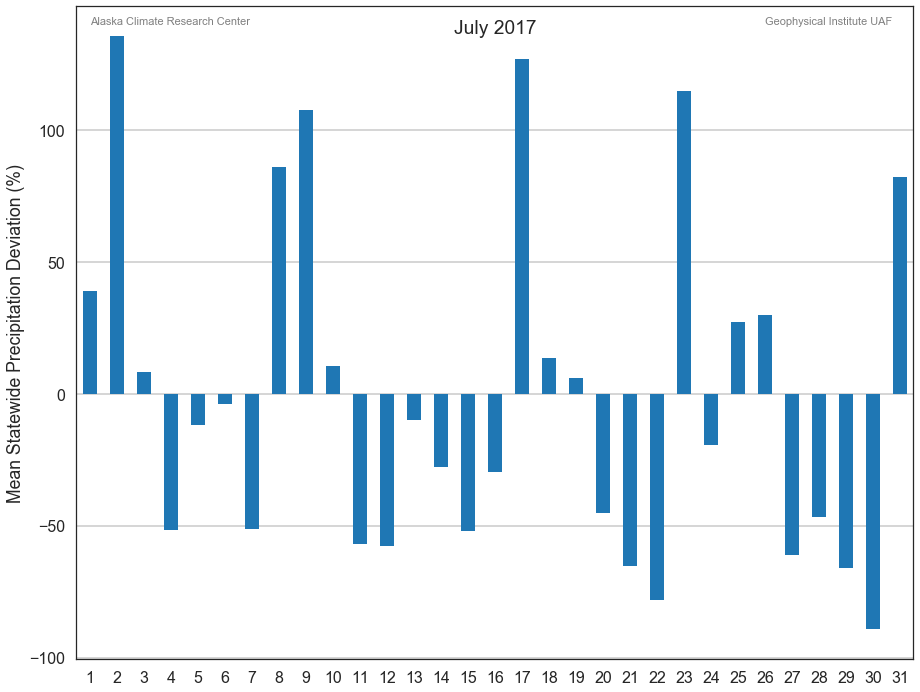

In [97]:
fig, ax1 = plt.subplots(figsize=(15, 12))
avg_precip_dep.plot(
    x='xlabel',
    y='precip_dep',
    kind='bar', 
    ax=ax1,
    legend=False,
)
ticklabels = ax1.set_xticklabels(avg_precip_dep['xlabel'], rotation=0)
ax1.text(0, 140, "Alaska Climate Research Center", fontsize=11, color="grey")
ax1.text(25, 140, "Geophysical Institute UAF", fontsize=11, color="grey")
ax1.set_ylabel("Mean Statewide Precipitation Deviation (%)")
ax1.set_xlabel("")
ax1.set_title("July 2017", y=0.95)
ax1.grid(True, axis='y')

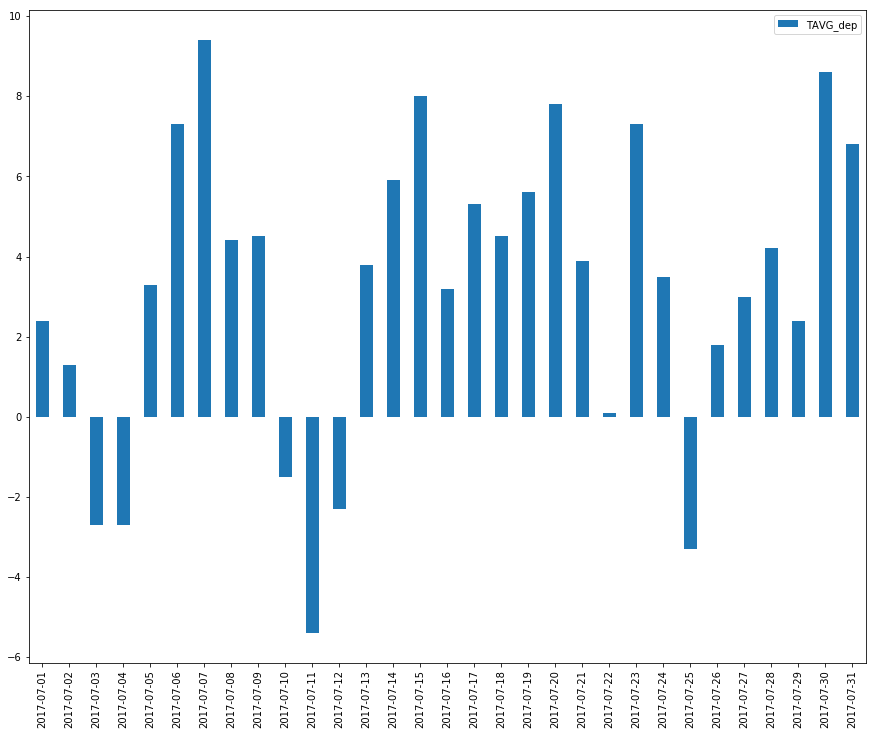

In [91]:
fig, ax = plt.subplots(figsize=(15, 12))
dataforstation.plot(y='TAVG_dep', kind='bar', ax=ax)

In [66]:
normalsforstation.index = dataforstation.index

In [68]:
(dataforstation['TAVG'] - normalsforstation['DLY-TAVG-NORMAL'])

2017-07-01    2.4
2017-07-02    1.3
2017-07-03   -2.7
2017-07-04   -2.7
2017-07-05    3.3
2017-07-06    7.3
2017-07-07    9.4
2017-07-08    4.4
2017-07-09    4.5
2017-07-10   -1.5
2017-07-11   -5.4
2017-07-12   -2.3
2017-07-13    3.8
2017-07-14    5.9
2017-07-15    8.0
2017-07-16    3.2
2017-07-17    5.3
2017-07-18    4.5
2017-07-19    5.6
2017-07-20    7.8
2017-07-21    3.9
2017-07-22    0.1
2017-07-23    7.3
2017-07-24    3.5
2017-07-25   -3.3
2017-07-26    1.8
2017-07-27    3.0
2017-07-28    4.2
2017-07-29    2.4
2017-07-30    8.6
2017-07-31    6.8
dtype: float64